In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2022-03-07')

## Timeline hospitalisations

In [3]:
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data_spatial, get_sciensano_COVID19_data
from covid19_DTM.visualization.output import color_timeframes

In [13]:
df_hosp, df_mort, df_cases, df_vacc = get_sciensano_COVID19_data(update=False)
sciensano_df_public = df_hosp[['H_in']].groupby('date').sum().ewm(span=10).mean()
sciensano_values_public = sciensano_df_public.values
sciensano_dates_public = sciensano_df_public.index + pd.Timedelta(hours=12)

# Key dates
t4 = pd.Timestamp(2020, 3, 19, 0, 0) 
t5 = pd.Timestamp(2020, 5, 4, 0, 0)
t8 = pd.Timestamp(2020, 7, 1, 0, 0)
t11 = pd.Timestamp(2020, 10, 19, 0, 0)
t17 = pd.Timestamp(2021, 4, 26, 0, 0) 
t22 = pd.Timestamp(2021, 7, 19, 0, 0) 
t26 = pd.Timestamp(2021, 11, 17, 0, 0) 

## VOCs

In [5]:
from covid19_DTM.data import VOC, model_parameters
from covid19_DTM.models.TDPF import make_VOC_function

# Load data
df_VOC_abc = VOC.get_abc_data()
df_VOC_delta = VOC.get_delta_data()
df_VOC_omicron = VOC.get_omicron_data()
# Load VOC function
VOC_params, vaccine_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(VOCs=['WT','abc','delta','omicron'])
VOC_function = make_VOC_function(VOC_params['logistic_growth'])
# Compute fractions
states = param = 0
VOCs = np.zeros([len(sciensano_dates_public),4])
for i, t in enumerate(sciensano_dates_public):
    VOCs[i] = VOC_function(t, states, param)[0,:]

## Vaccines

In [6]:
##################################
## Import the necessary modules ##
##################################

from covid19_DTM.data import sciensano
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

################################
## Define simulation settings ##
################################

# Number of simulations for structural uncertainty
N = 18
# Number of cores to use for the simulations
processes = 18
# Confidence level used to visualise model fit
conf_int = 0.05
# Spatial aggregation
agg = 'prov'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'prov_test-age-groups_SAMPLES_2023-05-10.json'

##############################
## Define results locations ##
##############################

# Path where MCMC samples should be saved
samples_path = '../../../data/covid19_DTM/interim/model_parameters/calibrations/'+agg+'/'

#############################
## Load samples dictionary ##
#############################

from covid19_DTM.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict['end_calibration']
samples_dict['end_calibration'] = '2021-10-21'

##########################
## Initialize the model ##
##########################

model, base_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                update_data=False, start_date=start_calibration,
                                                                                stochastic=True)

#######################
## Sampling function ##
#######################

from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fnc

In [8]:
#########################
## Perform simulations ##
#########################

print('\n1) Simulating COVID-19 SEIRD '+str(N)+' times')
out = model.sim([pd.to_datetime(start_calibration), end_date], tau=0.5, N=1, processes=1)


1) Simulating COVID-19 SEIRD 18 times


In [9]:
x_model = out['date'].values
y_model = out['S'].sum(dim=['age_groups'])+out['E'].sum(dim=['age_groups'])+out['I'].sum(dim=['age_groups'])+out['A'].sum(dim=['age_groups'])+out['R'].sum(dim=['age_groups'])

In [10]:
from covid19_DTM.data.utils import construct_initN
initN=construct_initN()

## Make figure

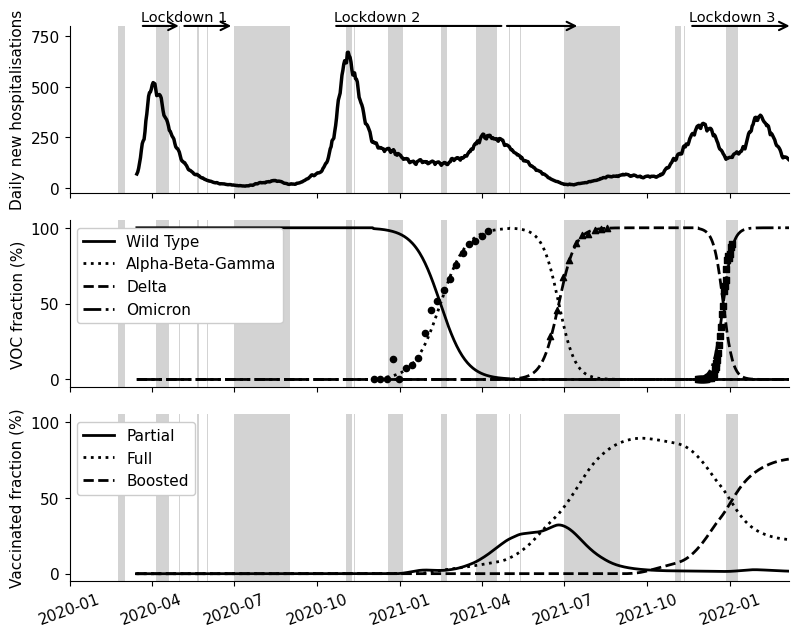

In [18]:
# General settings
ticklabelsize = 11

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8.27,0.8*8.27))

######################
## Hospitalisations ##
######################

ax = axes[0]

# Hospitalisations
ax.set_ylabel('Daily new hospitalisations', size=ticklabelsize)
ax.plot(sciensano_dates_public, sciensano_values_public, linewidth=2.5, color='black')

# Axes limits
ylim=800
ax.set_ylim([None, ylim])
ax.set_yticks([0,250,500,750])

# Add arrows denoting lockdown periods
label_lockdown_size = 10.5
label_lockdown_move_up = 25
arrow_height = ylim
# First lockdown
ax.annotate(text='', xy=(t4, arrow_height), xytext=(t5,arrow_height), \
            arrowprops=dict(arrowstyle='<-',linewidth=1.5))
ax.text(t4 + pd.Timedelta(days=1), \
        ylim + label_lockdown_move_up, 'Lockdown 1', size=label_lockdown_size)
# Lockdown release
ax.annotate(text='', xy=(t5, arrow_height), xytext=(t8,arrow_height), \
            arrowprops=dict(arrowstyle='<-',linewidth=1.5))
# Second lockdown
label_lockdown1_move_right = -2.5 # days
ax.annotate(text='', xy=(t11, arrow_height), xytext=(t17,arrow_height), \
            arrowprops=dict(arrowstyle='-',linewidth=1.5))
ax.text(t11 + pd.Timedelta(days=1), \
        ylim + label_lockdown_move_up, 'Lockdown 2', size=label_lockdown_size)
arrow_height = ylim
# Lockdown release
ax.annotate(text='', xy=(t17, arrow_height), xytext=(t22,arrow_height), \
            arrowprops=dict(arrowstyle='<-', linewidth=1.5))
# Third lockdown
ax.annotate(text='', xy=(t26, arrow_height), xytext=(end_date+pd.Timedelta(days=4),arrow_height), \
            arrowprops=dict(arrowstyle='<-', linewidth=1.5))
ax.text(t26 + pd.Timedelta(days=0), \
        ylim + label_lockdown_move_up, 'Lockdown 3', size=label_lockdown_size)

##########
## VOCs ##
##########

ax = axes[1]

# Overlay hospitalisations
ax.plot(sciensano_dates_public, VOCs[:,0]*100, linewidth=2, color='black')
ax.plot(sciensano_dates_public, VOCs[:,1]*100, linewidth=2, color='black', linestyle='dotted')
ax.plot(sciensano_dates_public, VOCs[:,2]*100, linewidth=2, color='black', linestyle='dashed')
ax.plot(sciensano_dates_public, VOCs[:,3]*100, linewidth=2, color='black', linestyle='-.')
ax.scatter(df_VOC_abc.index, df_VOC_abc*100, color='k', marker='o', s=20)
ax.scatter(df_VOC_delta.index, df_VOC_delta*100, color='k', marker = '^', s=20)
ax.scatter(df_VOC_omicron.index, df_VOC_omicron*100, color='k', marker = 's', s=20)
ax.set_ylabel('VOC fraction (%)', size=ticklabelsize)
ax.legend(['Wild Type', 'Alpha-Beta-Gamma', 'Delta', 'Omicron'], loc='upper left', framealpha=1, fontsize=ticklabelsize)
ax.set_ylim(-5, 105)
ax.set_yticks([0,50,100])

##############
## Vaccines ##
##############

ax=axes[2]

ax.plot(x_model, y_model.sel(doses='partial')/np.sum(initN.loc[slice(18,None)])*100, label='Partial',
            color='k', linewidth=2)
ax.plot(x_model, y_model.sel(doses='full')/np.sum(initN.loc[slice(18,None)])*100, label = 'Full',
            color='k', linestyle='dotted', linewidth=2)
ax.plot(x_model, y_model.sel(doses='boosted')/np.sum(initN.loc[slice(18,None)])*100, label = 'Boosted',
            color='k', linestyle='dashed', linewidth=2)
ax.set_ylim(-5, 105)
ax.set_yticks([0,50,100])
ax.legend(loc='upper left', framealpha=1, fontsize=ticklabelsize)
ax.set_ylabel('Vaccinated fraction (%)', size=ticklabelsize)

# General decorations
for ax in axes:
    ax.grid(False)
    ax.set_xlim(start_date, end_date)
    plt.setp(ax.get_xticklabels(), fontsize=ticklabelsize)
    plt.setp(ax.get_yticklabels(), fontsize=ticklabelsize)
    color_timeframes(start_date, end_date, ax=ax, week_color='white', weekend_color='white', vacation_color='lightgrey')
    
plt.xticks(rotation = 20)
plt.tight_layout()
plt.savefig('overview-hosp-VOC-vacc.pdf')
plt.show()
plt.close()